<br>
<img src="data/logoMoSEF.jpeg" width=90px align="left">
<div align="right">Enseignant : Amed Coulibaly</div>
<div align="right">Réalisé par : Gaoussou DIAKITE et Eunice KOFFI</div>
<div align="right">Année : 2022/2023</div><br><br><br>
<div align="center"><span style="font-family:Lucida Caligraphy;font-size:32px;color:darkgreen">Master 2 Modélistaion Statistiques Economiques et Financières</span></div><br>
<div align="center"><span style="font-family:Lucida Caligraphy;font-size:28px;color:#e60000">Projet Data Mining</span></div><br><br>
<hr>

<br>

<div align="center"><span style="font-family:Lucida Caligraphy;font-size:32px;color:darkgreen"> ** Machine Learning ** </span></div><br>
<hr>

Dans cette partie, il s'agit de proposer et implementer un modèle qui prédit la consommation électrique des communes dans l'agriculture, dans l'industrie et dans le residentiel. Pour cela, nous disposons d'une base de données `consommation` à laquelle nous rajouterons des informations de la base de données utilisée dans les autres analyses. Cette partie se déclinera en différents points que sont:
- Analyse et traitement des données
- Choix d'un modèle
- Validation du modèle
- Analyse des performances

**Importation des modules et packages**

In [1]:
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import statsmodels.discrete.discrete_model

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor

from yellowbrick.regressor import PredictionError
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.regressor import CooksDistance

**Lecture des bases de données**

In [2]:
consommation = pd.read_csv('data/conso-elec-gaz-annuelle-par-secteur-dactivite-agregee-commune-france.csv')
pop_tourisme = pd.read_csv('data/données.csv')

print('La base consommation a ', consommation.shape[0], 'lignes et ', consommation.shape[1], 'colones.')
print('La base pop_tourisme a ', pop_tourisme.shape[0], 'lignes et ', pop_tourisme.shape[1], 'colones.')

La base consommation a  46584 lignes et  36 colones.
La base pop_tourisme a  100 lignes et  85 colones.


**Jointures des bases de données**

*_Nous partons de l'intuition que la consommation électrique résidentielle prend en compte la consommation dans les hôtels, appartements,... 
Aussi, elle dépend de la population car plus une ville est peuplée, plus il y'aura des habitations et plus la consommation augmentera.
Les données relatives au tourisme sont des données de l'année 2022. Cependant, la consommation d'éléctricité prédite est celle de 2021. Nous allons donc garder que les données de la population en 2019._*

In [3]:
pop_tourisme = pop_tourisme[['libelle_departement', 'PMUN19']]

In [4]:
# Jointure des bases de données
table = consommation.merge(pop_tourisme,on="libelle_departement")
print('La base pop_tourisme a ', table.shape[0], 'lignes et ', table.shape[1], 'colones.')

La base pop_tourisme a  46567 lignes et  37 colones.


# Traitements des données et analyse exploratoire

Pour commencer analysons encore une fois les données que nous avons.

**Affichage des 5 premières lignes**

In [5]:
table.head()

,operateur,annee,filiere,consoa,pdla,nombre_maille_secretisees_a,indquala,consoi,pdli,nombre_maille_secretisees_i,...,code_epci,libelle_epci,code_departement,libelle_departement,code_region,libelle_region,id_filiere,consototale,code_postal,PMUN19
0,Coopérative d'électricité de Saint Martin de L...,2021,Electricité,96.656,12,0,0.420,0.000,0,1,...,200022986,CC du Grand Pic Saint-Loup,34,Hérault,76,Occitanie,100,2580.085,34380,1175623
1,Coopérative d'électricité de Saint Martin de L...,2021,Electricité,114.528,12,0,0.564,561.731,36,0,...,243400694,CC Vallée de l'Hérault,34,Hérault,76,Occitanie,100,15923.797,34570,1175623
2,Coopérative d'électricité de Saint Martin de L...,2021,Electricité,238.387,33,0,0.621,2849.502,36,0,...,243400355,CC du Clermontais,34,Hérault,76,Occitanie,100,18348.188,34230,1175623
3,Coopérative d'électricité de Saint Martin de L...,2021,Electricité,0.000,0,1,0.000,0.000,0,1,...,243400694,CC Vallée de l'Hérault,34,Hérault,76,Occitanie,100,1230.762,34230,1175623
4,Coopérative d'électricité de Saint Martin de L...,2021,Electricité,95.729,14,0,0.560,0.000,0,1,...,243400694,CC Vallée de l'Hérault,34,Hérault,76,Occitanie,100,2172.443,34150,1175623


**Affichage des informations de la table**

In [6]:
table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46567 entries, 0 to 46566
Data columns (total 37 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   operateur                     46567 non-null  object 
 1   annee                         46567 non-null  int64  
 2   filiere                       46567 non-null  object 
 3   consoa                        46567 non-null  float64
 4   pdla                          46567 non-null  int64  
 5   nombre_maille_secretisees_a   46567 non-null  int64  
 6   indquala                      46567 non-null  float64
 7   consoi                        46567 non-null  float64
 8   pdli                          46567 non-null  int64  
 9   nombre_maille_secretisees_i   46567 non-null  int64  
 10  indquali                      46567 non-null  float64
 11  consot                        46567 non-null  float64
 12  pdlt                          46567 non-null  int64  
 13  n

Nous allons apporter des modifications au fichier en fonction des attendus :
- Sélectionner que la consommation d'électricité
- Sélectionner que les secteurs l'agriculture, l'industrie et le résidentiel
- Supprimer toutes les colonnes que nous n'allons pas utliser
- Caluler la consommation d'éléctricité que pour les secteurs qui nous intéressent

**Sélection des secteurs et de la consommation d'électritré**

In [7]:
def cylindrage(df):
    table_c = df[df['filiere']=='Electricité']
    if (table_c['filiere'].unique() =='Electricité') == True:
        print('\nSélection de conso électrique -----> OK\n')
        print("* Le secteur sélectionné est : ", table_c['filiere'].unique()[0], '\n')
        
    new_table = table_c[
    (table_c['consoa'] !=0) 
    | (table_c['consoi'] !=0)
    | (table_c['consor'] !=0)
    ]
    print('Sélection des secteurs ---------> OK')
    print('\n* La nouvelle table a ', new_table.shape[0], ' observations et ', new_table.shape[1], 'variables.')
    return new_table
    

In [8]:
new_table = cylindrage(table)


Sélection de conso électrique -----> OK

* Le secteur sélectionné est :  Electricité 

Sélection des secteurs ---------> OK

* La nouvelle table a  35439  observations et  37 variables.


**Calcul de la consommation**

In [9]:
new_table['conso']= new_table['consoa'] + new_table['consoi'] + new_table['consor']

**Supression de variables**

Dans notre base de données, nous avons plusieurs variables avec une seule modalité. Ces variables doivent être supprimées car elles n'apportent aucune information pour notre modélisation. Nous avons également choisi de supprimer les variables relatives aux codes et garder les libéllés qui étaient plus faciles à comprendre.

In [10]:
variables = new_table.columns.tolist()

In [11]:
variable_a_supprimer = ['annee', 'code_commune', 'libelle_commune', 'code_postal', 'filiere','id_filiere',
                        'code_departement', 'code_region', 'code_epci', 'libelle_epci',
                       'consot', 'pdlt', 'nombre_maille_secretisees_t', 'indqualt', 'consototale',
                       'consona', 'pdlna', 'nombre_maille_secretisees_na', 'indqualna']

In [12]:
for elem in tqdm(variable_a_supprimer):
    variables.remove(elem)

  0%|          | 0/19 [00:00<?, ?it/s]

In [13]:
print(variables)
print(len(variables))

['operateur', 'consoa', 'pdla', 'nombre_maille_secretisees_a', 'indquala', 'consoi', 'pdli', 'nombre_maille_secretisees_i', 'indquali', 'consor', 'pdlr', 'nombre_maille_secretisees_r', 'indqualr', 'thermor', 'partr', 'libelle_departement', 'libelle_region', 'PMUN19', 'conso']
19


In [14]:
new_table = new_table[variables]
print(new_table.shape)

(35439, 19)


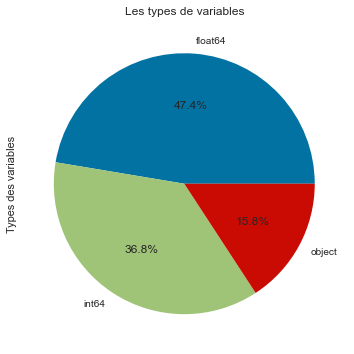

In [15]:
plt.figure(figsize=(8,6))
plt.title("Les types de variables")
new_table.dtypes.value_counts().plot(kind="pie",ylabel='Types des variables', autopct = lambda x: str(round(x, 1)) + '%')
plt.show()

In [16]:
def list_var(df):
    
    col_categoricals = []
    col_numericals_float = []
    col_numericals_int = []
    for col in df.columns :
        if df[col].dtypes == 'float64':
            col_numericals_float.append(col)
        elif df[col].dtypes == 'object' :
            col_categoricals.append(col)
        elif df[col].dtypes == 'int64':
            col_numericals_int.append(col)

    print(f"Liste des colonnes catégorielles :\n{col_categoricals}")
    print(f"\nListe des colonnes numériques décimales :\n{col_numericals_float}")
    print(f"\nListe des colonnes numériques entières :\n{col_numericals_int}")
    
    return col_categoricals, col_numericals_float, col_numericals_int

In [17]:
col_categoricals, col_numericals_float, col_numericals_int = list_var (new_table)

Liste des colonnes catégorielles :
['operateur', 'libelle_departement', 'libelle_region']

Liste des colonnes numériques décimales :
['consoa', 'indquala', 'consoi', 'indquali', 'consor', 'indqualr', 'thermor', 'partr', 'conso']

Liste des colonnes numériques entières :
['pdla', 'nombre_maille_secretisees_a', 'pdli', 'nombre_maille_secretisees_i', 'pdlr', 'nombre_maille_secretisees_r', 'PMUN19']


# Visualisations de données et traitement de données

## Visualisation de données

### Variables quantitatives

In [18]:
print("\n-----------------------------------------Statistiques des variables quantitatives---------------------------------\n")
new_table[col_numericals_float].describe()


-----------------------------------------Statistiques des variables quantitatives---------------------------------



,consoa,indquala,consoi,indquali,consor,indqualr,thermor,partr,conso
count,35439.000000,35439.000000,3.543900e+04,35439.000000,35439.000000,35439.000000,35439.000000,35439.000000,3.543900e+04
mean,200.958748,0.486773,3.272588e+03,0.439913,4780.373531,0.717026,0.481674,6.426341,8.253920e+03
std,616.455008,0.417533,3.794747e+04,0.447984,16261.947206,0.174717,2.030328,11.118511,4.305028e+04
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,1.803000e+00
25%,0.000000,0.000000,0.000000e+00,0.000000,643.355157,0.701000,0.000000,0.000000,7.859948e+02
50%,63.587314,0.682000,4.891535e+00,0.327000,1496.323821,0.775000,0.000000,0.000000,1.842547e+03
75%,183.557586,0.882000,3.903409e+02,0.906000,3726.489086,0.811000,0.329773,16.950000,5.085676e+03
max,34240.956125,1.000000,4.361012e+06,2.000000,909274.759871,1.000000,110.015237,84.400000,4.361012e+06


Nous constatons que : 
- Pour certaines variables des valeurs sont nulles jusqu'au 2e quartile. Ceci est normale car si la commune n'est pas dans ce secteur la valeur de la variable associée est égale à 0. 
- Toutes les variables ont un même nombre de valeurs non nulles.
- Les variables sont asymétriques

Pour confirmer ou infirmer nos observations nous continuons nos analyses avec une visualisation de la distribution des variables.

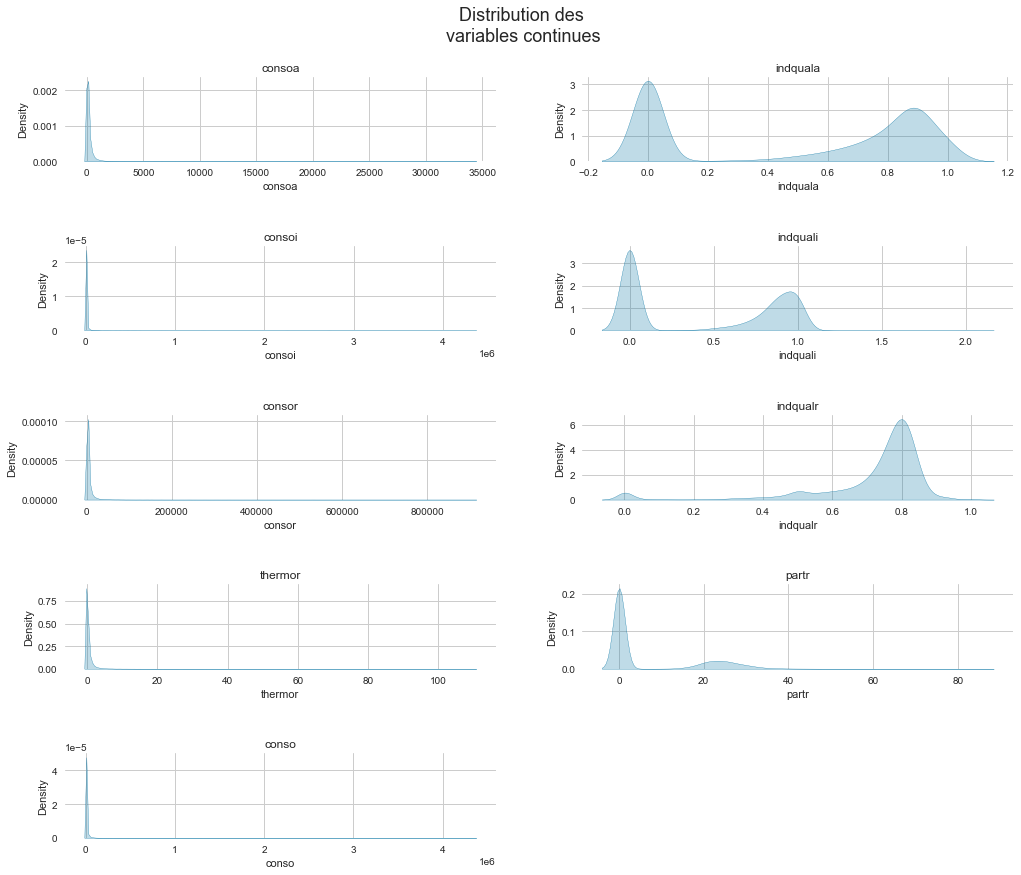

In [19]:
ncols = 2
nrows = len(col_numericals_float) // ncols + (len(col_numericals_float) % ncols > 0)
 
plt.figure(figsize=(17, 14))
plt.subplots_adjust(hspace=1)
plt.suptitle("Distribution des \nvariables continues", fontsize=18, y=0.95)
 
for n, variable in enumerate(col_numericals_float):
    # add a new subplot iteratively
    ax = plt.subplot(nrows, ncols, n + 1)
 
    sns.kdeplot(ax=ax, data=new_table[variable], legend=None, shade=True)
    ax.grid(b=True, which='major', axis='y')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    ax.set_title(variable, loc= 'center', fontsize=12)

### Variables qualitatives

In [20]:
# Affichage du nombre de modalités par variable
for col in col_categoricals:
    print(f"La variable {col} contient {new_table[col].nunique()} modalités.") 

La variable operateur contient 115 modalités.
La variable libelle_departement contient 100 modalités.
La variable libelle_region contient 17 modalités.


Nos variables contiennent beaucoup de modalités, nous allons donc faire un graphique uniquement avec la variable libelle_region qui contient le moins de variable.

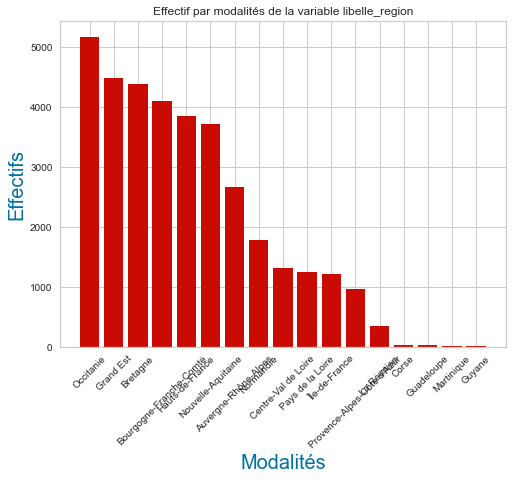

In [21]:
fig, ax = plt.subplots(figsize=(8,6))
ax.bar(x=new_table['libelle_region'].unique(), height=new_table['libelle_region'].value_counts(), color='r')
ax.set_xlabel(xlabel='Modalités' ,color='b', size=20)
ax.set_ylabel(ylabel='Effectifs' ,color='b', size=20)
plt.xticks(rotation = 45)
plt.title("Effectif par modalités de la variable libelle_region")
plt.show()

La région la plus représentée dans notre jeu de données est la région Occitanie. La moins représentée est celle de la Guyane.

## Traitement des données

### Gestion des valeurs manquantes

In [22]:
def display_missing_values(df):
    count_missing_val = {}
    for c in df.columns:
        nb_miss = ((df[c].isna()) | (df[c].astype(str).str.strip()==""))*1
        nb_miss = nb_miss.sum()
        count_missing_val.update({c:[nb_miss,nb_miss/df.shape[0]]})
    
    res = pd.DataFrame(count_missing_val).T
    res = res.reset_index()
    res.columns = ['variable','nb_missing','pct_missing']
    
    display(res.sort_values('nb_missing',ascending=False))

In [23]:
display_missing_values(new_table)

,variable,nb_missing,pct_missing
0,operateur,0.0,0.0
10,pdlr,0.0,0.0
17,PMUN19,0.0,0.0
16,libelle_region,0.0,0.0
15,libelle_departement,0.0,0.0
14,partr,0.0,0.0
13,thermor,0.0,0.0
12,indqualr,0.0,0.0
11,nombre_maille_secretisees_r,0.0,0.0
9,consor,0.0,0.0


Nous n'avons pas de valeurs manquantes. Notre observation à partir du premier tableau est donc avérée.

### Gestion des outliers

In [24]:
def is_outlier(df,column):
    
    # 1er Quartile 
    Q1 = df[df[column].notna()][column].quantile(0.25)
    
    # 3ème Quartile 
    Q3 = df[df[column].notna()][column].quantile(0.75)
    
    # Inter-Quartile Range (IQR)
    IQR = Q3 - Q1
    
    # limites, basse & haute
    limite_inf = Q1-1.5*IQR
    limte_sup = Q3+1.5*IQR
    
    # Remplace les données inférieur et supérieur à la limite par 1 et les autres par 0
    series = (~(df[column].between(limite_inf,limte_sup)))*1
    
    return series

In [25]:
outlier_table=new_table.copy()
for target_col in tqdm(col_numericals_float):
    outlier_table[target_col+'_is_outlier'] = is_outlier(outlier_table,target_col)

  0%|          | 0/9 [00:00<?, ?it/s]

In [26]:
outliers_count = {}
for target_col in tqdm(col_numericals_float):
    outliers_count.update({target_col:[outlier_table[target_col+'_is_outlier'].sum()]})

df_res = pd.DataFrame(outliers_count).T
df_res = df_res.reset_index()
df_res.columns = ['variable','nb_outlier']
df_res['pct_outlier'] = df_res["nb_outlier"]/outlier_table.shape[0]
df_res.sort_values('nb_outlier',ascending=False)

  0%|          | 0/9 [00:00<?, ?it/s]

,variable,nb_outlier,pct_outlier
2,consoi,6326,0.178504
6,thermor,5314,0.149948
8,conso,4620,0.130365
5,indqualr,4088,0.115353
4,consor,4085,0.115268
0,consoa,3513,0.099128
7,partr,47,0.001326
1,indquala,0,0.000000
3,indquali,0,0.000000


Cette analyse vient confirmer nos observations sur le graphique des densités. Cependant, comme dit plus haut, il n'est pas nécessaire d'effectuer des traitements sur les outliers qui sont inhérentes à notre base de données.

# Analyse des corrélations et tests statistiques

## Corrélation de Pearson

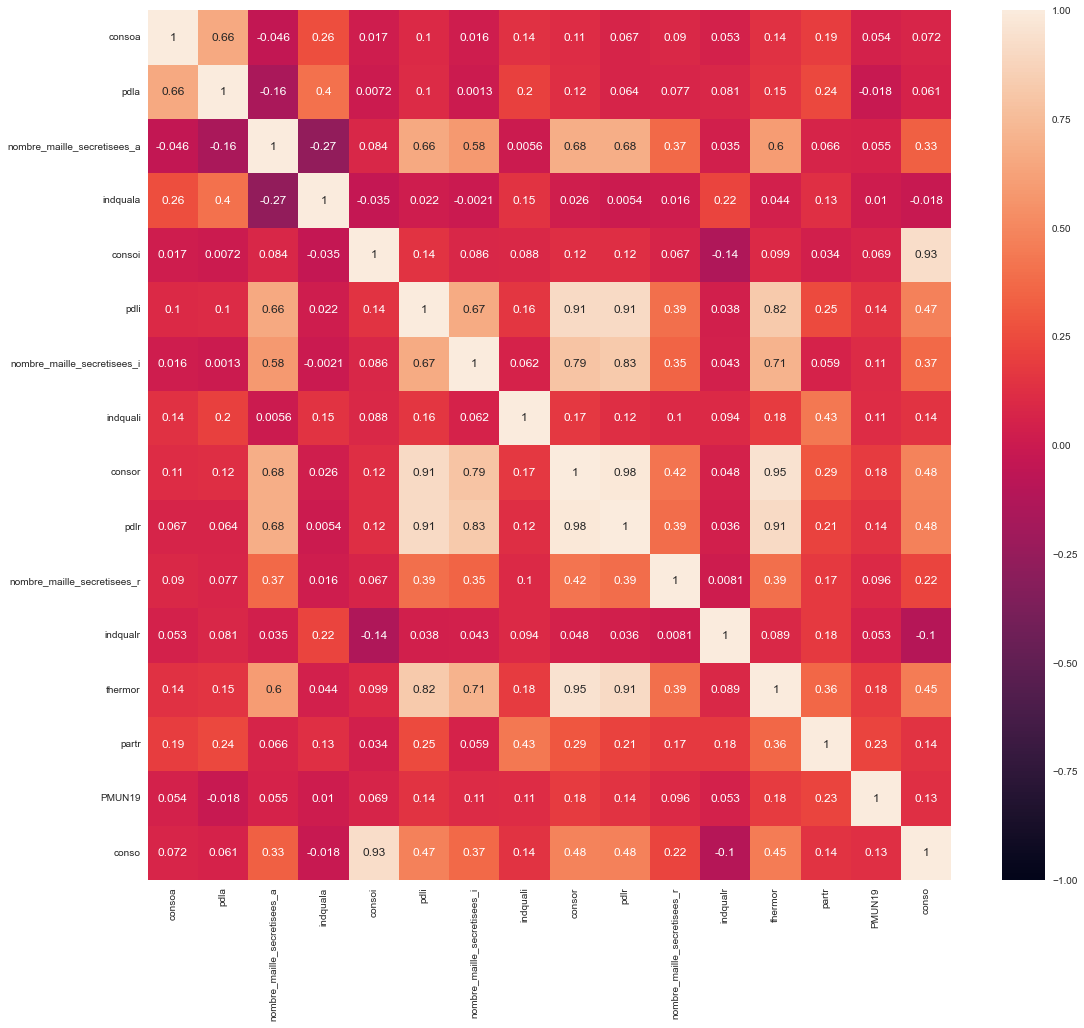

In [27]:
plt.figure(figsize = (18, 16))
sns.heatmap(new_table.corr(), annot=True, vmin=-1,vmax=1)
plt.show()

Nous avons de fortes corrélations entre les variables. Il faudra introduire dans notre modèles un paramètre de régularisation ou même faire une sélection de variable qui nous permettra d'éviter les erreurs causées par la multicolinéarité. Les variables les plus corrélées à notre target sont les consommations dans les sectuers individualisé.

Les variables quantitatives les plus corrélées à la target sont données par le graphique ci-dessous.

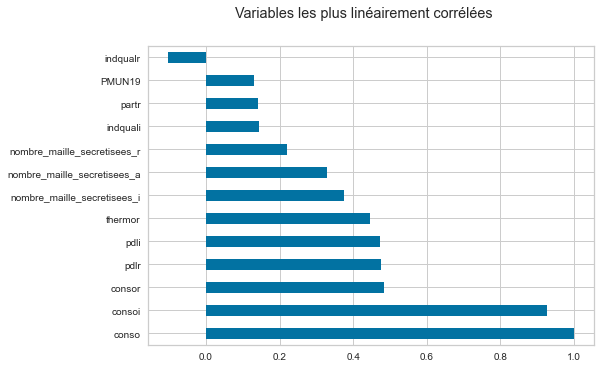

In [28]:
corr_matrix = new_table.corr()
var_corr = corr_matrix['conso'].reindex(corr_matrix['conso'].abs().sort_values(ascending = False).index)[0:13]
var_corr.plot(kind = 'barh')
plt.suptitle('Variables les plus linéairement corrélées')
plt.show()

## One way ANOVA

Pour analyser la corrélation entre la consommation et les départements, nous effectuons le test d'ANOVA.

In [29]:
print("**Tests statistiques entre les variables catégorielles et les variable à expliquer**\n")

print(" # Consommation et libelle region")
oneway = smf.ols('conso ~ libelle_region', new_table).fit()
print(sm.stats.anova_lm(oneway, typ=2))
print("\n")

print(" # Consommation et operateur")
oneway = smf.ols('conso ~ operateur', new_table).fit()
print(sm.stats.anova_lm(oneway, typ=2))
print("\n")

print(" # Consommation et libelle departement")
oneway = smf.ols('conso ~ libelle_departement', new_table).fit()
print(sm.stats.anova_lm(oneway, typ=2))
print("\n")

**Tests statistiques entre les variables catégorielles et les variable à expliquer**

 # Consommation et libelle region
                      sum_sq       df          F         PR(>F)
libelle_region  9.716148e+11     16.0  33.242891  3.971264e-102
Residual        6.470658e+13  35422.0        NaN            NaN


 # Consommation et operateur
                 sum_sq       df          F  PR(>F)
operateur  6.006612e+12    114.0  31.190839     0.0
Residual   5.967158e+13  35324.0        NaN     NaN


 # Consommation et libelle departement
                           sum_sq       df         F  PR(>F)
libelle_departement  3.637248e+12     99.0  20.92732     0.0
Residual             6.204094e+13  35339.0       NaN     NaN




Au seuil de 5%, on rejette l'hypothèse nulle selon laquelle toutes nos variables qualitatives n'ont pas un impact sur la consommation d'électricité. La localisation a donc un impact sur la consommation. On dirait que les régions ont des consommations différentes.

# Modélisation

Il s'agit d'un problème de régession car notre variable à expliquer est une variable continue. Nous commencerons par les modèles les plus simples pour aller ver les plus complexes soit les méthodes ensemblistes. Les modèles utilisés seront donc les suivant :
- Régression linéaire avec Statsmodels
- Régression linéaire avec Scikit-learn
- Régression linéaire avec Elasticnet
- Gradient Boosting

## Split des données et cross validation

**Supression de variables**

In [30]:
var_sup = ['libelle_region', 'operateur','libelle_departement', 'consoa', 'consor', 'consoi']
table_clean = new_table.drop(var_sup, axis=1)

**Normalisation**

La normalisation des données consiste à mettre toutes les variables sur la même échelle, ce qui peut améliorer l'efficacité de l'apprentissage et rendre les résultats plus faciles à interpréter. Nous allons donc normaliser nos données en utilisant la méthode normalize de Scikit-learn.

In [31]:
X_norm=preprocessing.normalize(table_clean, axis=0)
col=table_clean.columns
X_3=pd.DataFrame(X_norm, columns=col)
X_3.head()

,pdla,nombre_maille_secretisees_a,indquala,pdli,nombre_maille_secretisees_i,indquali,pdlr,nombre_maille_secretisees_r,indqualr,thermor,partr,PMUN19,conso
0,0.004005,0.000000,0.003479,0.000000,0.003553,0.000000,0.000303,0.0,0.003246,0.0,0.0,0.007388,0.000271
1,0.004005,0.000000,0.004672,0.004072,0.000000,0.004120,0.001787,0.0,0.003620,0.0,0.0,0.007388,0.001498
2,0.011013,0.000000,0.005144,0.004072,0.000000,0.004315,0.002074,0.0,0.004146,0.0,0.0,0.007388,0.001787
3,0.000000,0.005166,0.000000,0.000000,0.003553,0.000000,0.000189,0.0,0.004175,0.0,0.0,0.007388,0.000143
4,0.004672,0.000000,0.004639,0.000000,0.003553,0.000000,0.000299,0.0,0.003318,0.0,0.0,0.007388,0.000243


**Standardisation des données** 

In [32]:
SS=StandardScaler()
col=table_clean.columns
X_stan=SS.fit_transform(table_clean)
X_2=pd.DataFrame(X_stan, columns=col)
X_2.head(2)

,pdla,nombre_maille_secretisees_a,indquala,pdli,nombre_maille_secretisees_i,indquali,pdlr,nombre_maille_secretisees_r,indqualr,thermor,partr,PMUN19,conso
0,0.316553,-0.541241,-0.159925,-0.217745,0.313098,-0.981997,-0.146888,-0.147196,-1.522637,-0.237243,-0.577994,0.990463,-0.139689
1,0.316553,-0.541241,0.184963,0.566837,-0.409714,0.105111,0.138341,-0.147196,-1.225008,-0.237243,-0.577994,0.990463,0.095454


Nous travaillons avec les données normalisées.

In [33]:
# X_2, X_3, table_clean

X = X_3.drop('conso', axis=1)
y = X_3['conso']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

In [34]:
print("Les dimensions des différents jeu de données")
print("Ensemble : ", new_table.shape)
print("Train : ", y_train.shape, X_train.shape)
print("Test : ", y_test.shape, X_test.shape)

Les dimensions des différents jeu de données
Ensemble :  (35439, 19)
Train :  (24807,) (24807, 12)
Test :  (10632,) (10632, 12)


## Métriques d'évaluation

Nous sommes dans un problème de régression linéaire. Nous allons de ce fait utiliser comme métriques d'évvaluation:
- La fonction `r2_score` qui calcule le coefficient de détermination.
Il représente la proportion de variance (de y) qui a été expliquée par le variables indépendantes dans le modèle. Il fournit une indication de la qualité d'ajustement et donc une mesure de la probabilité que les échantillons non vus soient prédit par le modèle, à travers la proportion de variance expliquée.
- La fonction `mean_squared_error` calcule la moyennes des carré des erreurs. 
C'est une mesure du risque correspondant à la valeur attendue de l’erreur au carré (quadratique) ou de la perte. Cette métrique nous permet d'évaluer la différence entre les valeurs estimées et les vraies valeurs.
- Le `median_absolute_error` est particulièrement intéressant parce qu’il est robuste aux valeurs aberrantes.
La perte est calculée en prenant la médiane de tous les absolus différences entre la cible et la prédiction.

## Régression Linéaire avec Statsmodel

In [35]:
import statsmodels.api as sm

model = sm.OLS(y_train, X_train)
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                  conso   R-squared (uncentered):                   0.245
Model:                            OLS   Adj. R-squared (uncentered):              0.245
Method:                 Least Squares   F-statistic:                              670.4
Date:                Sun, 08 Jan 2023   Prob (F-statistic):                        0.00
Time:                        23:46:41   Log-Likelihood:                          95674.
No. Observations:               24807   AIC:                                 -1.913e+05
Df Residuals:                   24795   BIC:                                 -1.912e+05
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
                                  coef    std err          t      P>|t|      [0.025      0.975]
------------------------

Les résultats obtenus nous montre la siginificativité de nos variables dans notre modèle.
Les coefficients obtenus s'interprètre comme suit :
- Si le nombre de maille sécrétisées du secteur de l'industrie augmente de 1 unité, la conosmmation augmentera de 0.0505 MWH toute chose égale par ailleurs.
- Si le pourcentage de la consommation annuelle du secteur résidentiel augmente de 1 %, la conosmmation baissera de 0.1974 MWH toute chose égale par ailleurs.

## Régression Linéaire avec Sklearn

=====LinearRegression=====
Score Test: 0.465641800756052
MAE: 0.0008232511257767449
MSE: 6.552602064532467e-06


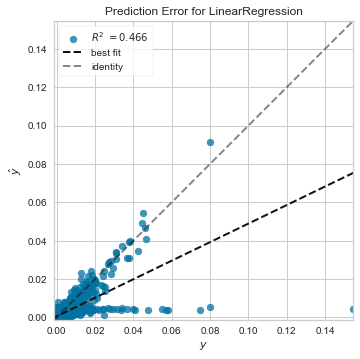

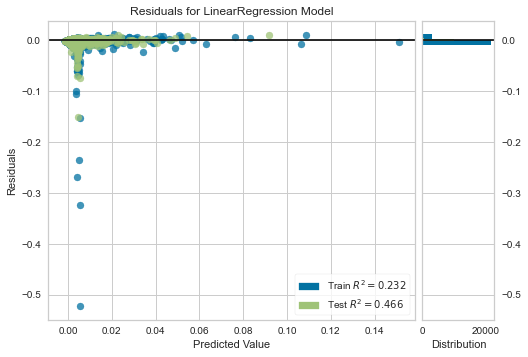

In [36]:
lr = LinearRegression()
lr.fit(X_train,y_train)
print("=====LinearRegression=====")
print("Score Test:",lr.score(X_test,y_test))
pred_lr = lr.predict(X_test)

print("MAE:",mean_absolute_error(y_test,pred_lr))
print("MSE:",mean_squared_error(y_test,pred_lr))


visualizer = PredictionError(lr)
visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)        
visualizer.show();   

visualizer = ResidualsPlot(lr)
visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test) 
visualizer.show();

Notre modèle explique 46.6% de la variance de la consommation d'électricité dans les trois secteurs. La valeur du MSE également reste faible. Cependant nous constatons la présence, sur le graph de nuage de points, des outliers.

In [37]:
coefficients = lr.coef_
print("intercept(b0):",lr.intercept_)
x=0
for col in X_train.columns:
    print(f"Le coefficient associé à la variable {col} est : {(coefficients[x])}")
    x+=1

intercept(b0): 0.002589797416193143
Le coefficient associé à la variable pdla est : 0.024382916680746873
Le coefficient associé à la variable nombre_maille_secretisees_a est : 0.020388003670658947
Le coefficient associé à la variable indquala est : -0.02093320960982202
Le coefficient associé à la variable pdli est : 0.22005855946773373
Le coefficient associé à la variable nombre_maille_secretisees_i est : 0.031678291849315615
Le coefficient associé à la variable indquali est : 0.11069086749883411
Le coefficient associé à la variable pdlr est : 0.1535927900579383
Le coefficient associé à la variable nombre_maille_secretisees_r est : 0.009019100170908276
Le coefficient associé à la variable indqualr est : -0.5925082054888969
Le coefficient associé à la variable thermor est : 0.07772511612898982
Le coefficient associé à la variable partr est : -0.007215789064514031
Le coefficient associé à la variable PMUN19 est : 0.1110887413676699


Les coefficients obtenus avec la régression linéaire de scikit learn ont le même signe que ceux obtenus avec statsmodel.

## Elasticnet

Etant donné que nos variables sont corrélées entre elles, nous avons pensé à inclure dans notre modèle une régularisation. Nous avons choisi Elasticnet qui utilisait à la fois Lasso et Ridge.

**GridSearchCV**

In [38]:
enet_params = {"l1_ratio": [0,0.01,0.05,0.1,0.2,0.4,0.5,0.6,0.8,1],
              "alpha":[0.1,0.01,0.001,0.2,0.3,0.5,0.8,0.9,1,2,5,7,10,13,20,45,99,100]}
enet_model = ElasticNet().fit(X, y)
from sklearn.model_selection import GridSearchCV
gs_cv_enet = GridSearchCV(estimator = enet_model, param_grid=enet_params, cv = 5).fit(X, y)

gs_cv_enet.best_params_

{'alpha': 0.001, 'l1_ratio': 0}

In [40]:
enet_tuned = ElasticNet(**gs_cv_enet.best_params_).fit(X_train, y_train)
y_pred = enet_tuned.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

0.0033469221983414826

In [41]:
coefficients = enet_tuned.coef_
print("intercept(b0):",enet_tuned.intercept_)
x=0
for col in X_train.columns:
    print(f"Le coefficient associé à la variable {col} est : {(coefficients[x])}")
    x+=1

intercept(b0): 0.0009017574054223248
Le coefficient associé à la variable pdla est : 0.0013706888332937102
Le coefficient associé à la variable nombre_maille_secretisees_a est : 0.007666933159575132
Le coefficient associé à la variable indquala est : -0.0003713712580307063
Le coefficient associé à la variable pdli est : 0.012663932571326158
Le coefficient associé à la variable nombre_maille_secretisees_i est : 0.009014314476979453
Le coefficient associé à la variable indquali est : 0.0026659088303701076
Le coefficient associé à la variable pdlr est : 0.012473935653234746
Le coefficient associé à la variable nombre_maille_secretisees_r est : 0.005125471160828339
Le coefficient associé à la variable indqualr est : -0.0007465264577111214
Le coefficient associé à la variable thermor est : 0.011502301457586232
Le coefficient associé à la variable partr est : 0.0030325474967856625
Le coefficient associé à la variable PMUN19 est : 0.0021205283254592026


Les résultats obtenus ont également le même signe.

## GradientBoosting

Sachant que les méthodes ensemblistes ont la capacité de regrouper plusieurs algorithmes faibles pour effectuer une prédiction plus robuste.

=====GradientBoostingRegressor=====
Score Test: 0.5562019871664472
MAE: 0.0004117526214587923
MSE: 5.442101907003686e-06


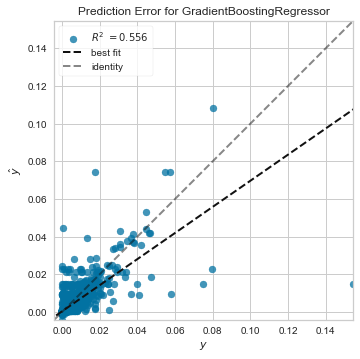

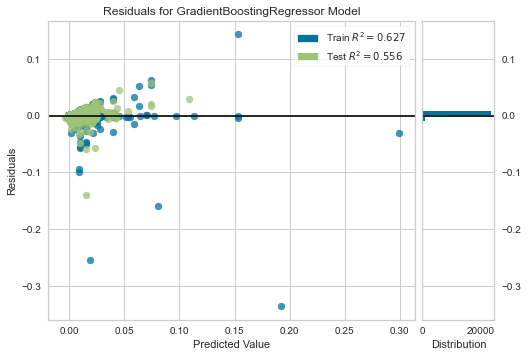

In [42]:
gb = GradientBoostingRegressor()
gb.fit(X_train,y_train)
print("=====GradientBoostingRegressor=====")
print("Score Test:",gb.score(X_test,y_test))
pred_gb = gb.predict(X_test)
print("MAE:",mean_absolute_error(y_test,pred_gb))
print("MSE:",mean_squared_error(y_test,pred_gb))

visualizer = PredictionError(gb)
visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)
visualizer.show(); 

visualizer = ResidualsPlot(gb)
visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show();

In [43]:
coefficients = gb.coef_
print("intercept(b0):",gb.intercept_)
x=0
for col in X_train.columns:
    print(f"Le coefficient associé à la variable {col} est : {(coefficients[x])}")
    x+=1

AttributeError: 'GradientBoostingRegressor' object has no attribute 'coef_'